# Parallel computing

This brief example will show how to take advantage of multiple processors using the Julia function pmap in the `Distributed.jl` package.

## Julia Environment
First we must set up the Julia environment. In particular, we must download the `OpticalBlochEquations` package from GitHub and add it to our environment. We can run the built-in tests, if we wish. After that, we will add a number of other packages that we will need to display the data. 

In [1]:
using Pkg
Pkg.activate("myEnvironment")

  Activating project at `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment`


In [2]:
ENV["JULIA_SSL_CA_ROOTS_PATH"]=""

""

In [3]:
Pkg.add(url="https://github.com/floriansLU/OpticalBlochEquations.jl")

    Updating git-repo `https://github.com/floriansLU/OpticalBlochEquations.jl`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`


In [4]:
#Pkg.test("OpticalBlochEquations")

In [5]:
Pkg.add("BenchmarkTools");
Pkg.add("Plots");
Pkg.add("PlotlyBase");
Pkg.add("PlotlyKaleido");
Pkg.add("Profile")
Pkg.add("DataFrames")
Pkg.add("CSV")
using Distributed;
addprocs(Sys.CPU_THREADS);
using BenchmarkTools;
using OpticalBlochEquations
using DataFrames
using CSV
using Plots
plotly()

   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Project.toml`
  No Changes to `C:\Users\User\OneDrive\Jupyter-notebooks\COMPHY-revision\myEnvironment\Manifest.toml`
   Resolving package versions...
  No Changes to

Plots.PlotlyBackend()

## Parallel Computation
In order for `pmap` to be able to distribute the task to multiple processes, the functions must be made available to all processes. We can make all functions available by enclosing them between 
`@everywhere begin` and `end` macros. 

In [103]:
@everywhere begin
  using OpticalBlochEquations
  using DataFrames
  using CSV
  par = param(cesiumD1)
  laz = laser(Ωᵣ=1.0)  # 3-->3 transition
  e_vec_i = ElectricVector([0,1,0], 0, π / 2, pi/2).cyclic
  e_vec_n = ElectricVector([0,1,0], 0, π / 2, π / 2).cyclic
  e_vec_z = ElectricVector([0,1,0], 0, π / 2, π / 4).cyclic
  evecs=(e_vec_i,e_vec_n,e_vec_z)
  Doppler_steps=150
  #Brange=[-1.0,-0.8,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,-0.08,-0.06,-0.04,-0.02,0,0.02,0.04,0.06,0.08,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]
  #Brange=[-1.0,-0.5,0.5,1.0]  # this sort of worked
  Brange=[-1.0,-0.8,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,-0.06,-0.04,-0.02, 0.0, 0.02, 0.04, 0.06,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0]
  println("Laser frequecy: ",laz.ω_bar," MHz")
  println("Rabi frequecy: ",laz.Ωᵣ," MHz")
  
  signals_for_pmap(par, laz, evecs, Doppler_steps) = B₀ -> signals(B₀, par, laz, evecs, Doppler_steps)  
    
  resOmega1=pmap(signals_for_pmap(par, laz, evecs, Doppler_steps), Brange)
  

  xOmega1=Brange

end

Laser frequecy: 3.351205628e8 MHz
Rabi frequecy: 1.0 + 0.0im MHz
      From worker 9:	Laser frequecy: 3.351205628e8 MHz
      From worker 9:	Rabi frequecy: 1.0 + 0.0im MHz
      From worker 7:	Laser frequecy: 3.351205628e8 MHz
      From worker 7:	Rabi frequecy: 1.0 + 0.0im MHz
      From worker 8:	Laser frequecy: 3.351205628e8 MHz
      From worker 8:	Rabi frequecy: 1.0 + 0.0im MHz
      From worker 5:	Laser frequecy: 3.351205628e8 MHz
      From worker 5:	Rabi frequecy: 1.0 + 0.0im MHz
      From worker 3:	Laser frequecy: 3.351205628e8 MHz
      From worker 3:	Rabi frequecy: 1.0 + 0.0im MHz
      From worker 4:	Laser frequecy: 3.351205628e8 MHz
      From worker 6:	Laser frequecy: 3.351205628e8 MHz
      From worker 3:	Processing magnetic field B₀=-1.0 G.
      From worker 2:	Laser frequecy: 3.351205628e8 MHz
      From worker 7:	Processing magnetic field B₀=-1.0 G.
      From worker 8:	Processing magnetic field B₀=-1.0 G.
      From worker 9:	Processing magnetic field B₀=-1.0 G.
   

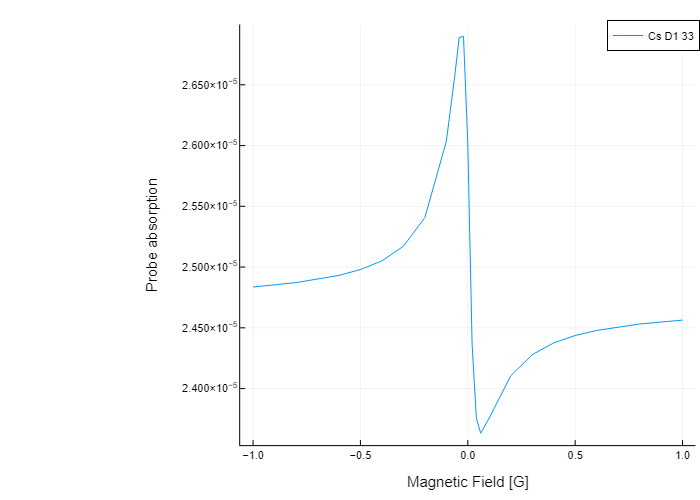

In [120]:
myResults=reshape(resOmega1,(length(resOmega1),1))
yOmega1=[]
for i in 1:length(myResults)
    append!(yOmega1,myResults[i][2] |> real)
end
#yOmega1=myResults[2,:] |> real;
  dfOmega1=DataFrame(B=xOmega1,Absorption=yOmega1)
  CSV.write("CsD1_33_Omega1.csv",dfOmega1)
  plot(xOmega1,yOmega1,xlabel="Magnetic Field [G]", ylabel="Probe absorption", label="Cs D1 33")